# Diffusion LaSDI-LS Example (MFEM Example 16)

In [1]:
import numpy as np
import numpy.linalg as LA

from scipy import sparse as sp
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse import linalg
from scipy.io import savemat,loadmat
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.dpi'] = 150 
from itertools import combinations_with_replacement, product
from tqdm.notebook import trange, tqdm
import sys,time
import os
import copy
import pickle
sys.path.append("..") # Adds higher directory to python modules path.
from LaSDI import LaSDI
import matplotlib

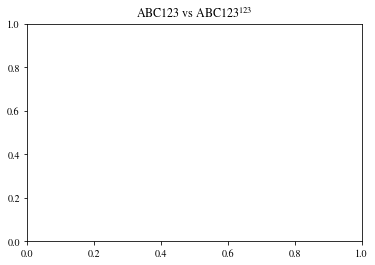

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['figure.dpi'] = 150

### Importing simulations, training parameters, etc.

In [3]:
# Given parameters
nx = 64
ny = 64
nxy = (ny)*(nx) # 3364
nt = 100
tstop = 1
dt = tstop/nt

In [4]:
training_rad = np.arange(90,130,20) 
training_iv = np.arange(190,230,20)
training_values = list(product(training_rad,training_iv))
nset = len(training_values)

In [5]:
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
X,Y = np.meshgrid(x,y, indexing = 'xy')

In [6]:
snapshot_matrix = np.empty([nxy, len(training_values)*nt])
for foo, sample in enumerate(training_values):
#     ex = np.load('./data/ex16_w_{}_a_{}.npz'.format(sample[0], sample[1]), allow_pickle = True)
    ex = np.load('../../../../../usr/WS1/fries4/Experiments/EX16/data/ex16_r{}_iv{}.npz'.format(sample[0], sample[1]), allow_pickle = True)
    ex = ex.f.arr_0
    ex = ex.T
    snapshot_matrix[:, nt*foo:nt*(foo+1)] = ex

### Generate POD matrix from training data

In [7]:
u,s,vh = LA.svd(snapshot_matrix)
sv_mass = np.cumsum(s)
sv_count = [i for i,ss in enumerate(sv_mass) if ss/sv_mass[-1]>.999][0]+1
# s[sv_count:] = 0
print(sv_count, sv_mass[:sv_count]/sv_mass[-1])
phi = u[:,:sv_count]

4 [0.96459033 0.99348022 0.99761283 0.99903405]


### Visualize Singular Values decay rate

(1e-06, 10000)

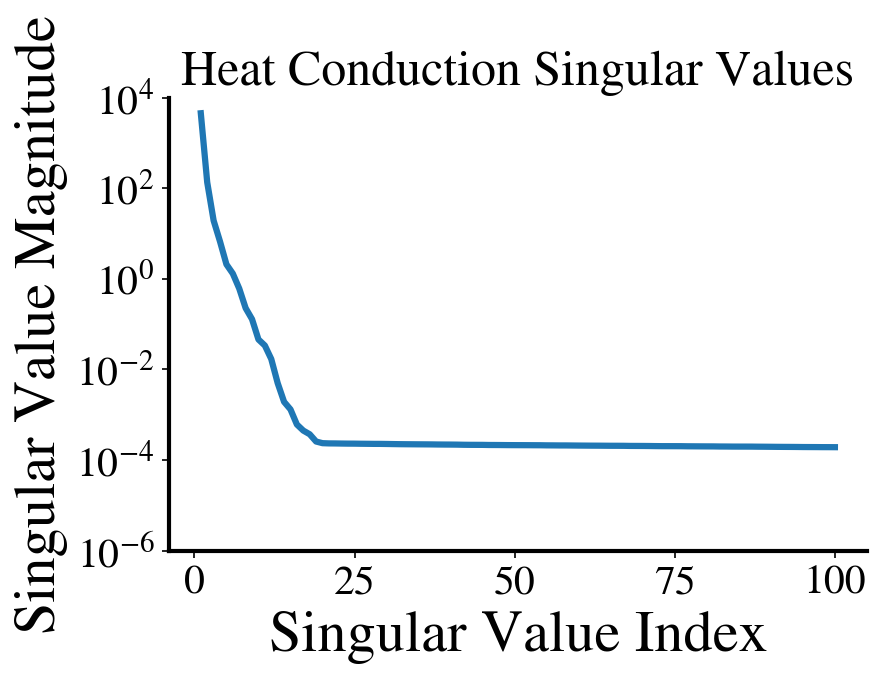

In [8]:
fig, ax = plt.subplots(1,1)
ax.set_title('Heat Conduction Singular Values')
ax.set_xlabel('Singular Value Index')
ax.set_ylabel('Singular Value Magnitude')
cut_off = 100
ax.plot(np.arange(1,cut_off+1),s[:cut_off])
ax.set_yscale('log')
ax.set_ylim(10e-7,10000)

### Generate latent-space trajectories from training data

In [9]:
latent_space_SS = []
for foo in range(nset):
    latent_space = np.matmul(phi.T, snapshot_matrix[:, nt*foo:nt*(foo+1)])
    latent_space_SS.append(latent_space.T)

### Generate LaSDI-LS Model

In [10]:
degree = 1
normal = 1
t = np.linspace(0,tstop,nt)
LaSDI_model = LaSDI(phi.T, phi)

x0' = 0.931 1 + 0.005 x0 + 0.144 x1 + 0.975 x2 + 3.961 x3
x1' = -2.764 1 + -0.140 x0 + -6.058 x1 + -3.885 x2 + -5.790 x3
x2' = -1.194 1 + -0.025 x0 + -2.375 x1 + -16.376 x2 + -12.789 x3
x3' = -6.206 1 + -0.043 x0 + -1.828 x1 + -13.361 x2 + -49.043 x3


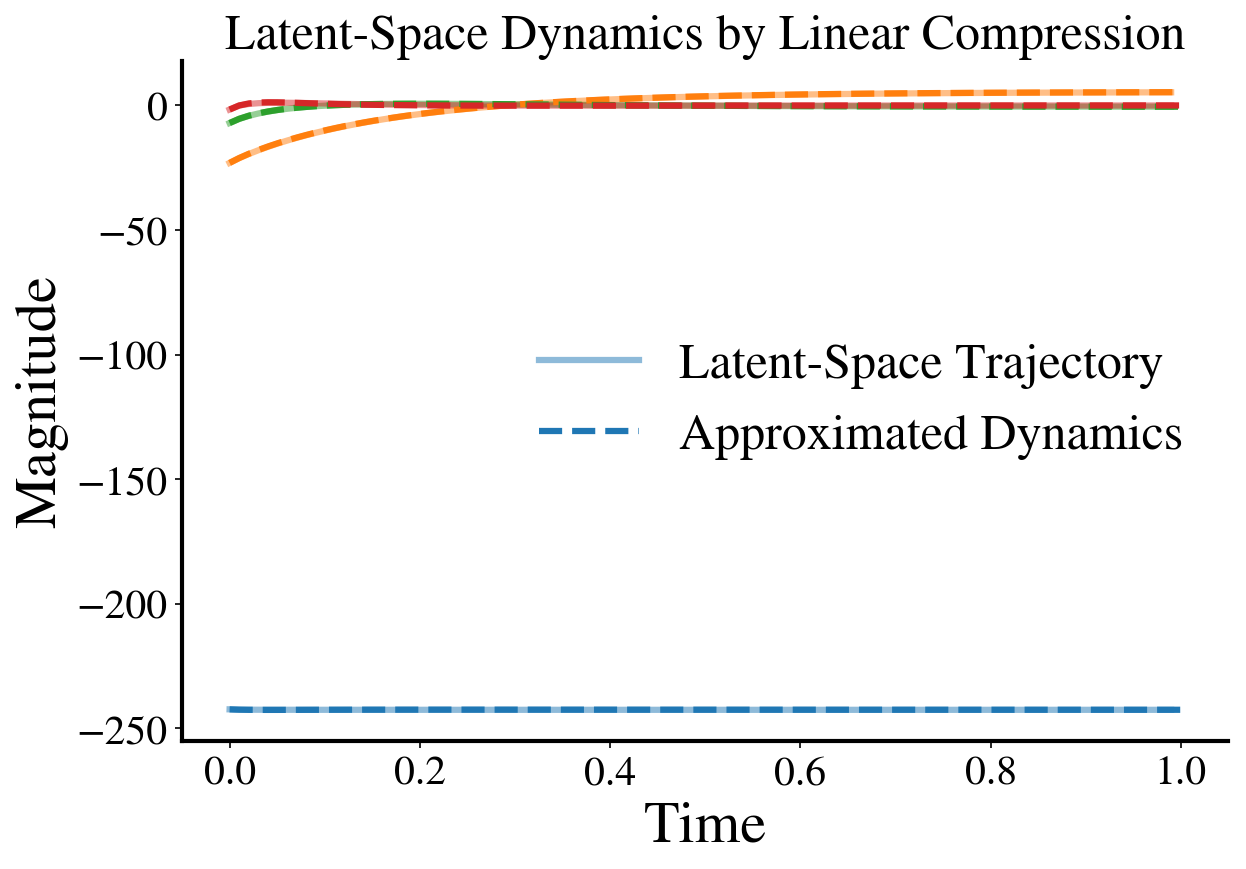

In [11]:
LaSDI_model.train_dynamics(latent_space_SS, training_values, dt)

### Generate ROM and visulaize results

In [12]:
# FOM = np.load('./data/ex16_w_{}_a_{}.npz'.format(100,200), allow_pickle = True)
FOM = np.load('../../../../../usr/WS1/fries4/Experiments/EX16/data/ex16_r{}_iv{}.npz'.format(100,200), allow_pickle = True)
FOM = FOM.f.arr_0
FOM = FOM
time_start = time.time()
FOM_recon = LaSDI_model.generate_ROM(FOM[0], [100,200],t)
LaSDI_time = time.time()-time_start

In [13]:
FOM_re = np.empty(nt)
for j in range(nt):
    FOM_re[j] = LA.norm(FOM_recon[j]-FOM[j])/LA.norm(FOM[j])
max_re = np.amax(FOM_re)*100
speed_up = 4.7/LaSDI_time

Text(0.5, 1.0, 'Relative Error')

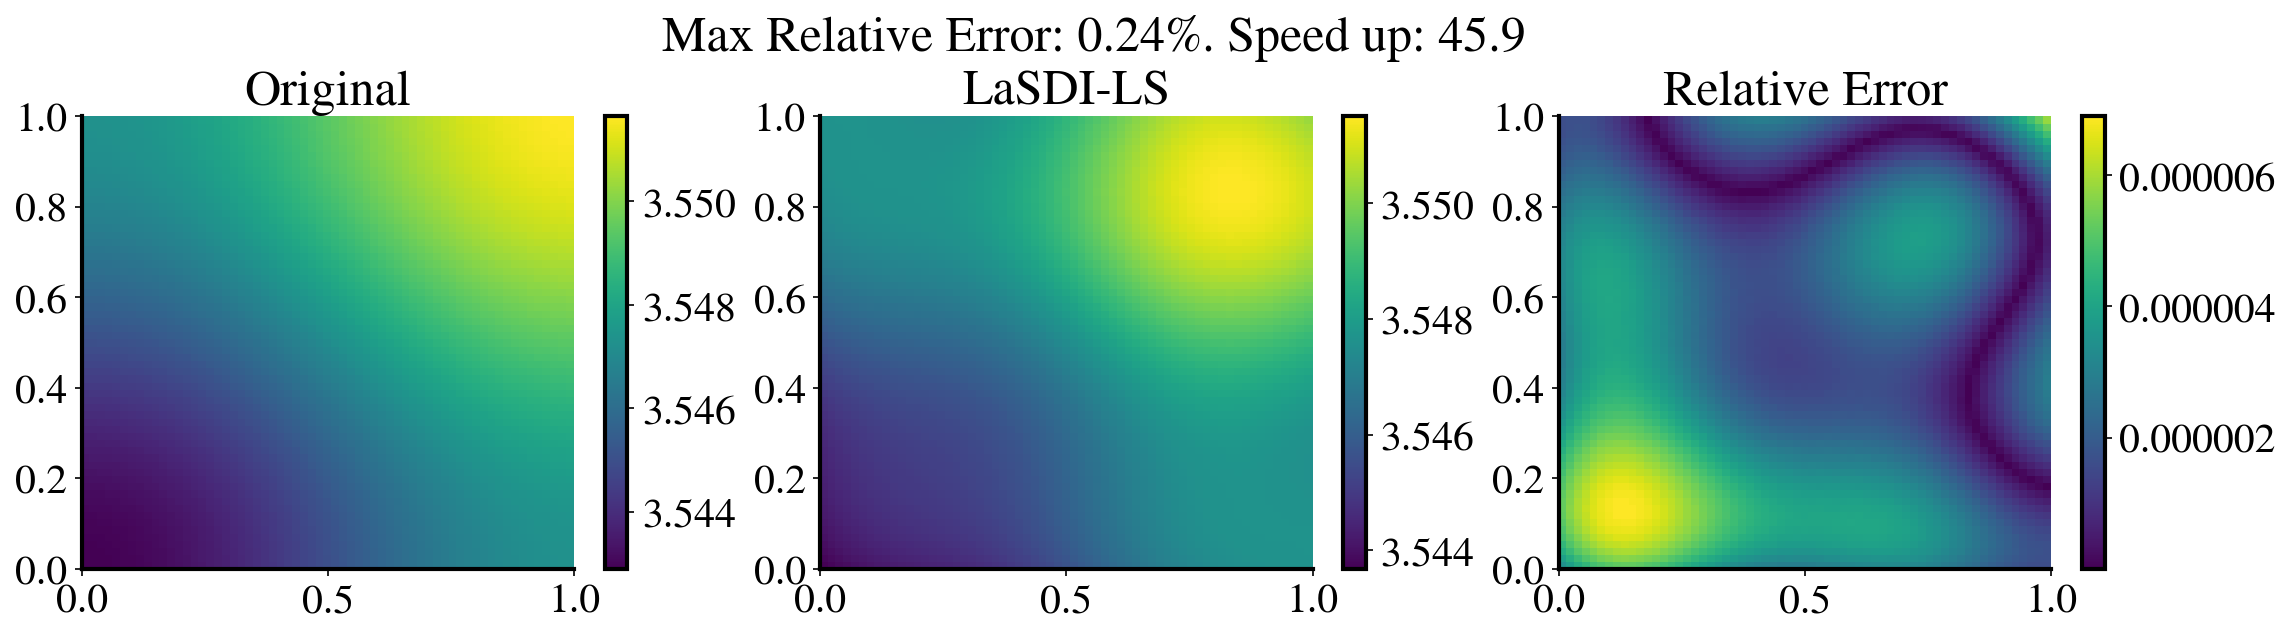

In [14]:
k=99
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
fig.set_size_inches(18,4)
z1=ax1.pcolormesh(X,Y,FOM[k].reshape(nx,ny), shading = 'nearest')
fig.suptitle('Max Relative Error: {:.2f}%. Speed up: {:.1f}'.format(np.amax(max_re), speed_up), y = 1.05)
# ax1.set_title('Time = 0.{}'.format(k))
fig.colorbar(z1, ax = ax1)
# ax1.axis('equal')
ax1.set_title('Original')
z1=ax2.pcolormesh(X,Y,FOM_recon[k].reshape(nx,ny), shading = 'nearest')
fig.colorbar(z1, ax = ax2)
# ax2.axis('equal')
ax2.set_title('LaSDI-LS')
ax3 = fig.add_subplot(1,3,3)
z1=ax3.pcolormesh(X,Y,np.abs(FOM_recon[k].reshape(nx,ny)-FOM[k].reshape(nx,ny))/LA.norm(FOM[k].reshape(nx,ny)), shading = 'nearest')
fig.colorbar(z1, ax = ax3)
# ax3.axis('equal')
ax3.set_title('Relative Error')

Text(0, 0.5, 'Relative Error (%)')

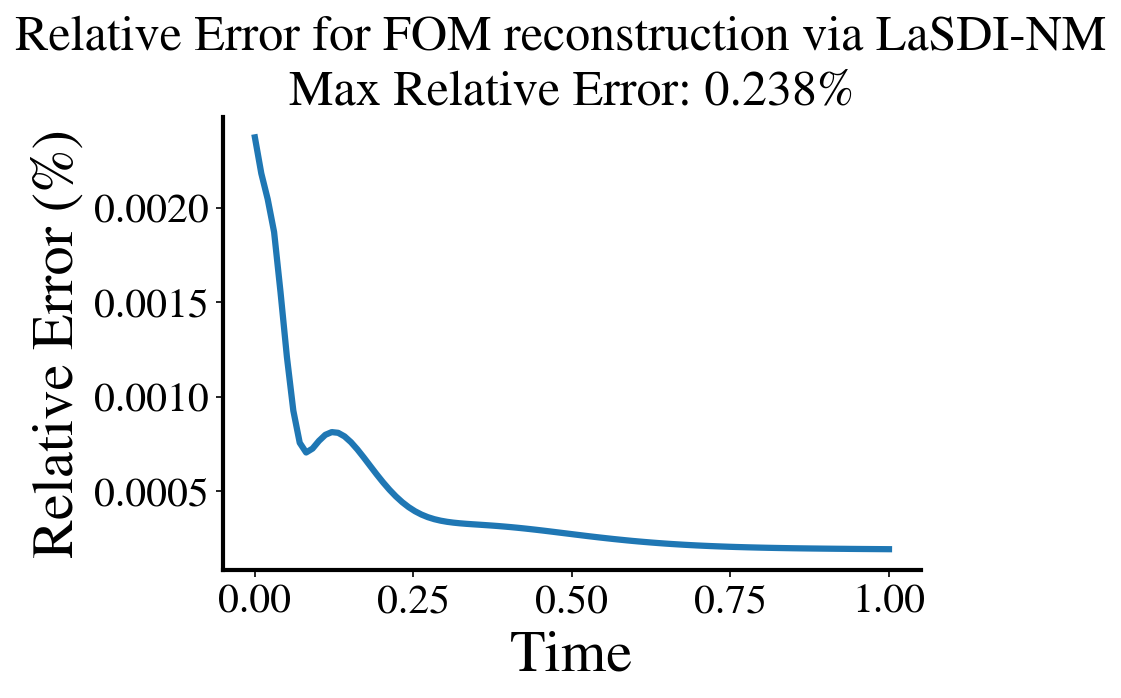

In [15]:
fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via LaSDI-NM', y = 1.05)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(max_re))
ax.plot(t, FOM_re)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')